## Analyse data from Joyce et al. 2021 GRL

### Procedure
- Use the dynamic atmospheric transport control data for Point Barrow (where eveything is variable). See file names.
- Aggregate data in yearly files into a pandas dataframe
- Calculate monthly means
- Read in Point Barrow observations data
- Plot simulated vs observed CO2 (Joyce figure S8)
- Apply ccgcrv to observed and simulations to get a fit to seasonal CO2
- Calculate CO2 seasonal amplitude changes and plot

In [1]:
# Set python environment to conda 'recovery' 
import pandas as pd
from pathlib import Path
import os
from glob import glob
import sys
import numpy as np
import matplotlib.pyplot as plt
from ccgcrv import ccg_dates

In [2]:
# Define a function to plot a regression line
def plot_linreg(x_in, y_in, col='grey', fmt='o', lab = '', alpha=0.7):
    from sklearn.linear_model import LinearRegression
    model = LinearRegression()  
    x = x_in.values.reshape(-1, 1) # sklearn fit requires a two dimensional array
    y = y_in.values.reshape(-1, 1)
    model.fit(x, y)
    y_pred = model.predict(x)
    r_sq = ": r_sq = {:.3f}".format(model.score(x, y))
    plt.plot(x, y, fmt, color=col, alpha=alpha,label=lab+r_sq)
    plt.plot(x, y_pred, '--', color=col)

In [6]:
# Read in files
file_brw_obs = Path("../data/stations/monthly/BRW_station_co2_observed_flask.csv")
file_brw_joyce_varyall = Path("../data/stations/BRW_CO2_monthly_joyce_varyall.csv")
brw_obs = pd.read_csv(file_brw_obs, header=0, names=['year', 'month', 'co2_obs'])
brw_jva = pd.read_csv(file_brw_joyce_varyall, header=0, names=['year', 'month', 'co2_joyce'])

In [7]:
# Merge the data
co2_brw = pd.merge(brw_obs, brw_jva, on=('year', 'month'))
co2_brw['decimal_year'] = np.round(co2_brw.apply(lambda row: ccg_dates.decimalDate(row['year'].astype(int),
        row['month'].astype(int), 1), axis=1), 2)

In [8]:
# Calculate linear trends and detrend

from sklearn.linear_model import LinearRegression

model = LinearRegression()

X = co2_brw.loc[:, 'decimal_year'].values.reshape(-1, 1) # sklearn fit requires a two dimensional array

nna = co2_brw["co2_obs"].notna()
y = co2_brw.loc[nna, 'co2_obs'].values.reshape(-1, 1)
model.fit(X[nna], y)
y_predict = model.predict(X)
co2_brw['co2_obs_tr'] = pd.Series(y_predict.reshape(-1))
co2_brw['co2_obs_dt'] = co2_brw['co2_obs'] - co2_brw['co2_obs_tr']

nna = co2_brw["co2_obs"].notna()
y = co2_brw.loc[nna, 'co2_joyce'].values.reshape(-1, 1)
model.fit(X[nna], y)
y_predict = model.predict(X)
co2_brw['co2_joyce_tr'] = pd.Series(y_predict.reshape(-1))
co2_brw['co2_joyce_dt'] = co2_brw['co2_joyce'] - co2_brw['co2_joyce_tr']
co2_brw.to_csv('co2_brw.csv')

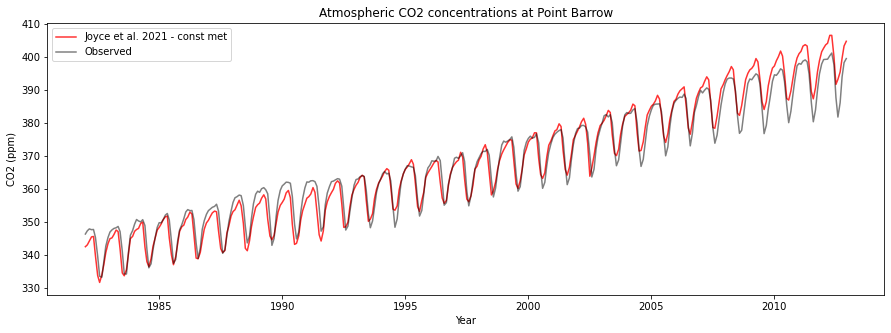

In [9]:
# Plot time series
plt.close()
plt.plot(co2_brw['decimal_year'], co2_brw['co2_joyce'], alpha=0.8, color='red', label='Joyce et al. 2021 - const met')
plt.plot(co2_brw['decimal_year'], co2_brw['co2_obs'], alpha=0.5, color='black', label='Observed')
plt.title('Atmospheric CO2 concentrations at Point Barrow')
plt.legend(loc="upper left")
plt.ylabel('CO2 (ppm)')
plt.xlabel('Year')
plt.show()

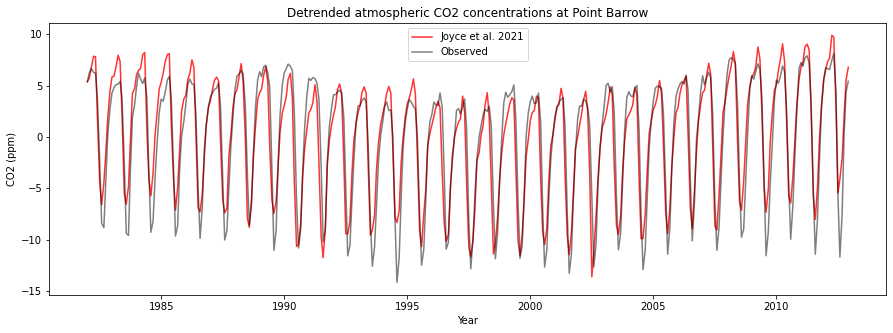

In [10]:
plt.clf()
plt.plot(co2_brw['decimal_year'], co2_brw['co2_joyce_dt'], alpha=0.8, color='red', label='Joyce et al. 2021')
plt.plot(co2_brw['decimal_year'], co2_brw['co2_obs_dt'], alpha=0.5, color='black', label='Observed')
plt.legend(loc="upper center")
plt.title('Detrended atmospheric CO2 concentrations at Point Barrow')
plt.ylabel('CO2 (ppm)')
plt.xlabel('Year')
plt.show()

### Fitting ccgcrv

In [11]:
# Define a function that calls the ccgcrv fit

def fit_ccgcrv(xp, yp, pars):
    # Prepares data and calls the ccgcrv fitting function
    # xp and yp are pandas Series (DataFrame columns)
    # pars is a dictionary of parameter values
    
    from ccgcrv_python import ccg_filter

    nna = yp.notna() # Need to remove missing values!
    xp = xp[nna].to_numpy()
    yp = yp[nna].to_numpy()

    # create the ccgfilt object
    filt = ccg_filter.ccgFilter(xp=xp, yp=yp,
        shortterm=pars['shortterm'], longterm=pars['longterm'], sampleinterval=pars['sampleinterval'],
        numpolyterms=pars['numpolyterms'], numharmonics=pars['numharmonics'], timezero=pars['timezero'],
        gap=pars['gap'], debug=pars['debug'], use_gain_factor= pars['use_gain_factor'])

    mm = filt.getMonthlyMeans()
    amps = filt.getAmplitudes()
    tcup, tcdown = filt.getTrendCrossingDates()

    # get x,y data for plotting
    x0 = filt.xinterp
    y1 = filt.getFunctionValue(x0)
    y2 = filt.getPolyValue(x0)
    y3 = filt.getSmoothValue(x0)
    y4 = filt.getTrendValue(x0)
    
    data_in = pd.DataFrame(data=np.array([xp, yp]).transpose(), columns=['year_dec', 'co2'])
    mod_out = pd.DataFrame(data=np.array([x0,y1,y2,y3,y4]).transpose(), columns=['year_dec', 'polyharm', 'poly', 'smooth', 'trend'])
    amplitude = pd.DataFrame(amps, columns=['year', 'amplitude', 'max_date', 'max_value', 'min_date', 'min_value'])
    tcross = pd.DataFrame(list(zip(tcup, tcdown)), columns=['tcup', 'tcdown'])
    out = {'data_in': data_in, 'model_out': mod_out, 'monthly_mean': mm, 'amplitude': amplitude, 'trend_cross': tcross}
    return(out)


In [12]:
# Set parameters and input data and call the ccgcrv function
pars = {
    'shortterm': 80,
    'longterm': 667,
    'sampleinterval': 0,
    'numpolyterms': 3,
    'numharmonics': 4,
    'timezero': -1,
    'gap': 0,
    'use_gain_factor': False,
    'debug': False
}

co2_brw = pd.read_csv('co2_brw.csv')

ccgfit_obs = fit_ccgcrv(xp=co2_brw["decimal_year"], yp=co2_brw["co2_obs"], pars=pars)
ccgfit_joyce = fit_ccgcrv(xp=co2_brw["decimal_year"], yp=co2_brw["co2_joyce"], pars=pars)


In [14]:
# # Try to get SZC
# # Function from ccgcrv module 
# def getZC(ccgfit):
# 	""" Get the dates when the smoothed curve crosses the trend curve.
# 	That is, when the detrended smooth seasonal cycle crosses 0.
# 	"""
# 	from ccgcrv_python.ccg_filter import harmonics

# 	# get harmonic part of function at interpolated data points
# 	ycycle = harmonics(ccgfit.params, ccgfit.xinterp-ccgfit.timezero, ccgfit.numpoly, ccgfit.numharm)

# 	# added short term smoothed data
# 	ycycle = ycycle + ccgfit.smooth - ccgfit.trend

# 	tcup = []
# 	tcdown = []
# 	ty = ycycle[0]
# 	for x, y in zip(ccgfit.xinterp, ycycle):

# 		if ty < 0.0 and y >= 0.0:
# 			tcup.append(x)
# 		if ty > 0.0 and y <= 0.0:
# 			tcdown.append(x)

# 		ty = y


# 	return (tcup, tcdown)

# zc = getZC(ccgfit_obs)

In [15]:
# Extract data from outputs
fit_obs = ccgfit_obs['model_out']
data_obs = ccgfit_obs['data_in']
amp_obs = ccgfit_obs['amplitude']
tcross_obs = ccgfit_obs['trend_cross']

fit_joyce = ccgfit_joyce['model_out']
data_joyce = ccgfit_joyce['data_in']
amp_joyce = ccgfit_joyce['amplitude']
tcross_joyce = ccgfit_joyce['trend_cross']


**Remove fitted trend from raw data and check yearly min, max and amplitude**

In [16]:
# Calculate values
co2_brw['co2_obs_dts'] = co2_brw.loc[:,'co2_obs'] - fit_obs['trend']
co2_brw['co2_joyce_dts'] = co2_brw.loc[:,'co2_joyce'] - fit_joyce['trend']
co2_brw_sub = co2_brw.loc[:,('year', 'co2_obs_dts', 'co2_joyce_dts')]

co2_brw_yavg = co2_brw_sub.groupby(['year'], as_index=False).agg(np.mean)
co2_brw_ymin = co2_brw_sub.groupby(['year'], as_index=False).agg(np.min)
co2_brw_ymax = co2_brw_sub.groupby(['year'], as_index=False).agg(np.max)
co2_brw_yamp = co2_brw_sub.groupby(['year'], as_index=False).agg(np.ptp)

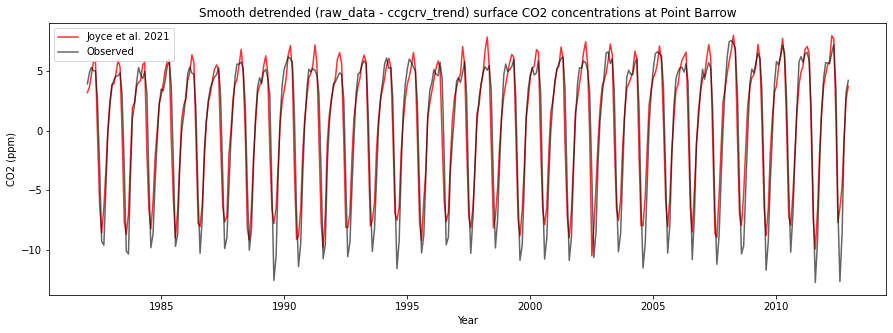

In [17]:
# Plot smooth-detrended raw data (data minus ccgcrv_trend)
# Set plot size, etc
plt.rcParams['figure.figsize'] = [15, 5]
plt.clf()
plt.plot(co2_brw['decimal_year'], co2_brw['co2_joyce_dts'], alpha=0.8, color='red', label='Joyce et al. 2021')
plt.plot(co2_brw['decimal_year'], co2_brw['co2_obs_dts'], alpha=0.6, color='black', label='Observed')
plt.legend(loc="upper left")
plt.title('Smooth detrended (raw_data - ccgcrv_trend) surface CO2 concentrations at Point Barrow')
plt.ylabel('CO2 (ppm)')
plt.xlabel('Year')
plt.show()

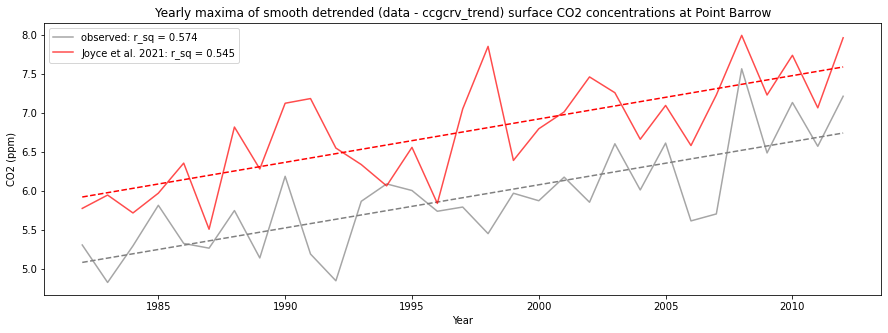

In [18]:
# Plot min, max and amplitude from smooth-detrended raw data
plt.clf()
plot_linreg(co2_brw_ymax['year'], co2_brw_ymax['co2_obs_dts'], col='grey', fmt='-', lab='observed')
plot_linreg(co2_brw_ymax['year'], co2_brw_ymax['co2_joyce_dts'], col='red', fmt='-', lab='Joyce et al. 2021')
plt.legend(loc="upper left")
plt.title('Yearly maxima of smooth detrended (data - ccgcrv_trend) surface CO2 concentrations at Point Barrow')
plt.ylabel('CO2 (ppm)')
plt.xlabel('Year')
plt.show()

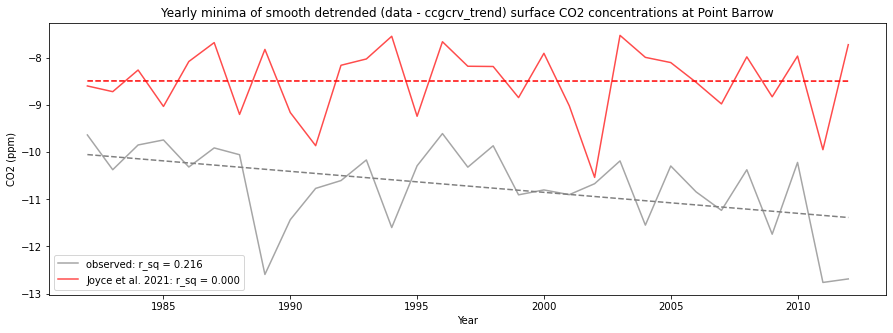

In [19]:
# Plot min, max and amplitude from smooth-detrended raw data
plt.clf()
plot_linreg(co2_brw_ymin['year'], co2_brw_ymin['co2_obs_dts'], col='grey', fmt='-', lab='observed')
plot_linreg(co2_brw_ymin['year'], co2_brw_ymin['co2_joyce_dts'], col='red', fmt='-', lab='Joyce et al. 2021')
plt.legend(loc="lower left")
plt.title('Yearly minima of smooth detrended (data - ccgcrv_trend) surface CO2 concentrations at Point Barrow')
plt.ylabel('CO2 (ppm)')
plt.xlabel('Year')
plt.show()

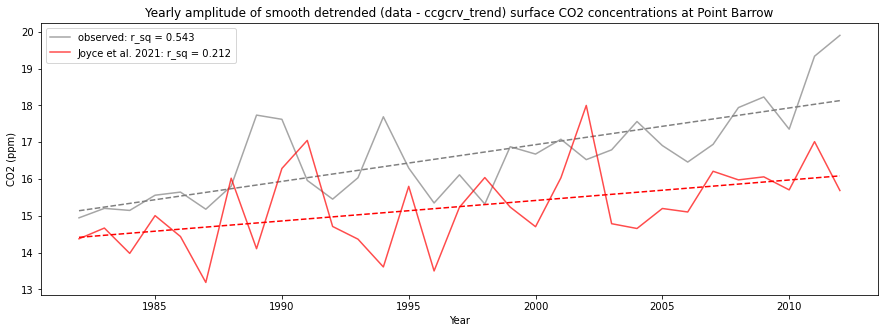

In [20]:
# Plot min, max and amplitude from smooth-detrended raw data
plot_linreg(co2_brw_yamp['year'], co2_brw_yamp['co2_obs_dts'], col='grey', fmt='-', lab='observed')
plot_linreg(co2_brw_yamp['year'], co2_brw_yamp['co2_joyce_dts'], col='red', fmt='-', lab='Joyce et al. 2021')
plt.legend(loc="upper left")
plt.title('Yearly amplitude of smooth detrended (data - ccgcrv_trend) surface CO2 concentrations at Point Barrow')
plt.ylabel('CO2 (ppm)')
plt.xlabel('Year')
plt.show()

### Plots of ccgcrv outputs

**Plot time series of fitted values**

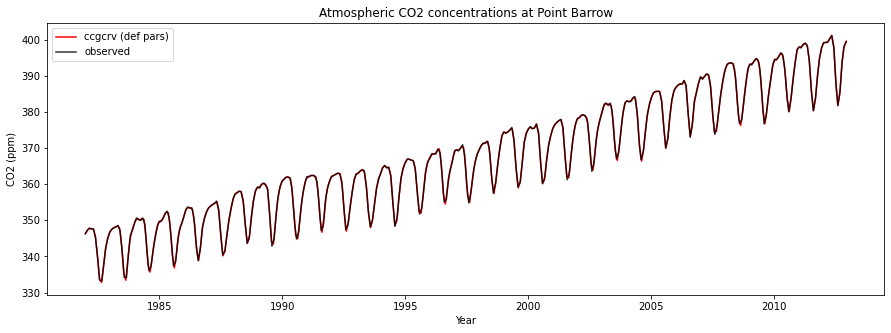

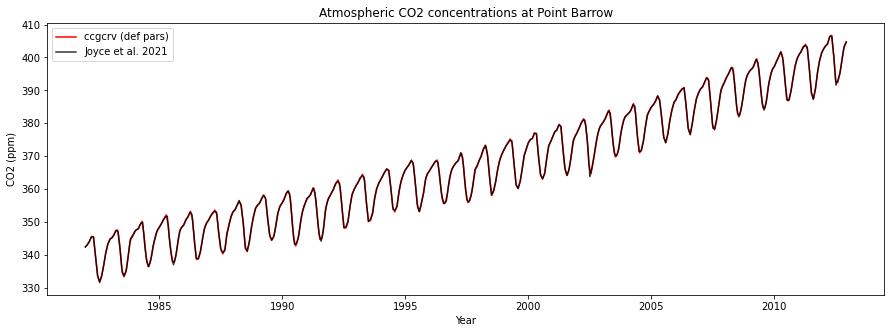

In [21]:
# Plot time series of CO2 values
plt.plot(fit_obs['year_dec'], fit_obs['smooth'], color="red", label='ccgcrv (def pars)')
plt.plot(data_obs['year_dec'], data_obs['co2'], color="black", label='observed', alpha=0.8)
plt.legend(loc="upper left")
plt.title('Atmospheric CO2 concentrations at Point Barrow')
plt.ylabel('CO2 (ppm)')
plt.xlabel('Year')
plt.show()

plt.plot(fit_joyce['year_dec'], fit_joyce['smooth'], color="red", label='ccgcrv (def pars)')
plt.plot(data_joyce['year_dec'], data_joyce['co2'], color="black", label='Joyce et al. 2021', alpha=0.8)
plt.legend(loc="upper left")
plt.title('Atmospheric CO2 concentrations at Point Barrow')
plt.ylabel('CO2 (ppm)')
plt.xlabel('Year')
plt.show()

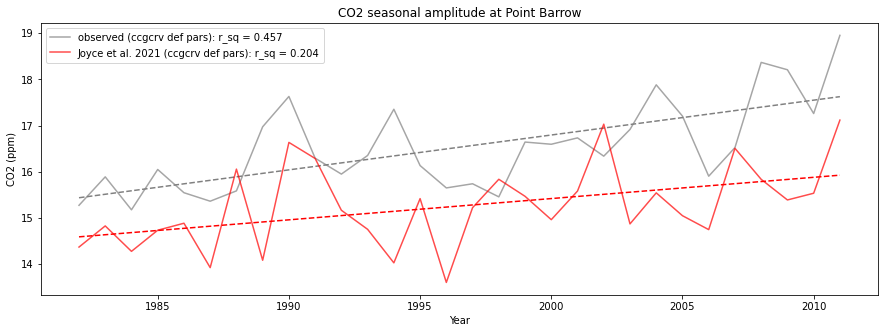

In [22]:
# Plot time series of CO2 seasonal amplitudes
plot_linreg(amp_obs['year'], amp_obs['amplitude'], col='grey', fmt='-', lab='observed (ccgcrv def pars)')
plot_linreg(amp_obs['year'], amp_joyce['amplitude'], col='red', fmt='-', lab='Joyce et al. 2021 (ccgcrv def pars)')
plt.legend(loc="upper left")
plt.title('CO2 seasonal amplitude at Point Barrow')
plt.ylabel('CO2 (ppm)')
plt.xlabel('Year')
plt.show()

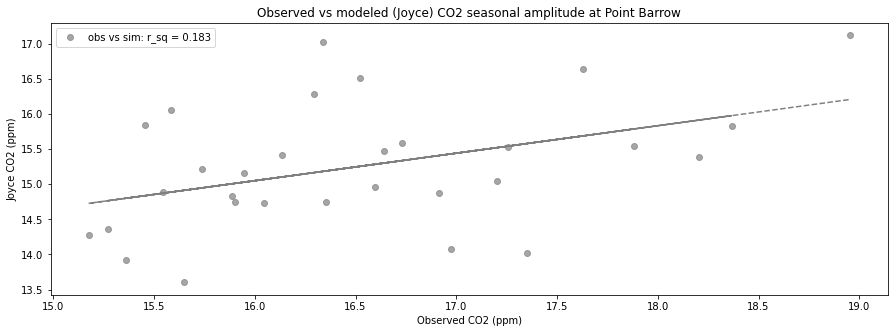

In [23]:
# Regression plot of obserbed vs modeled CO2 amplitude
plot_linreg(amp_obs['amplitude'], amp_joyce['amplitude'], col='grey', lab='obs vs sim')
plt.title('Observed vs modeled (Joyce) CO2 seasonal amplitude at Point Barrow')
plt.ylabel('Joyce CO2 (ppm)')
plt.xlabel('Observed CO2 (ppm)')
plt.legend(loc="upper left")
plt.show()

**Plots of trend crossing dates**

In [24]:
# Convert decimal year to date
def decyear_todate(decyear):
    from datetime import datetime, timedelta
    year = int(decyear)
    yearfrac = decyear - year
    base = datetime(year, 1, 1)
    date = base + timedelta(seconds=(base.replace(year=base.year + 1) - base).total_seconds() * yearfrac)
    return(date)

tcross_obs['tcup_date'] = pd.to_datetime(tcross_obs['tcup'].transform(decyear_todate)).round('D')
tcross_obs['tcdown_date'] = pd.to_datetime(tcross_obs['tcdown'].transform(decyear_todate)).round('D')
tcross_obs['tcup_doy'] = tcross_obs['tcup_date'].dt.strftime('%j').astype(int)
tcross_obs['tcdown_doy'] = tcross_obs['tcdown_date'].dt.strftime('%j').astype(int)
tcross_obs['tcup_frac'] = tcross_obs['tcup'] - tcross_obs['tcup'].astype(int)
tcross_obs['tcdown_frac'] = tcross_obs['tcdown'] - tcross_obs['tcdown'].astype(int)

tcross_joyce['tcup_date'] = pd.to_datetime(tcross_joyce['tcup'].transform(decyear_todate)).round('D')
tcross_joyce['tcdown_date'] = pd.to_datetime(tcross_joyce['tcdown'].transform(decyear_todate)).round('D')
tcross_joyce['tcup_doy'] = tcross_joyce['tcup_date'].dt.strftime('%j').astype(int)
tcross_joyce['tcdown_doy'] = tcross_joyce['tcdown_date'].dt.strftime('%j').astype(int)
tcross_joyce['tcup_frac'] = tcross_joyce['tcup'] - tcross_joyce['tcup'].astype(int)
tcross_joyce['tcdown_frac'] = tcross_joyce['tcdown'] - tcross_joyce['tcdown'].astype(int)

tcross_year = tcross_obs['tcdown_date'].dt.strftime('%Y').astype(int)


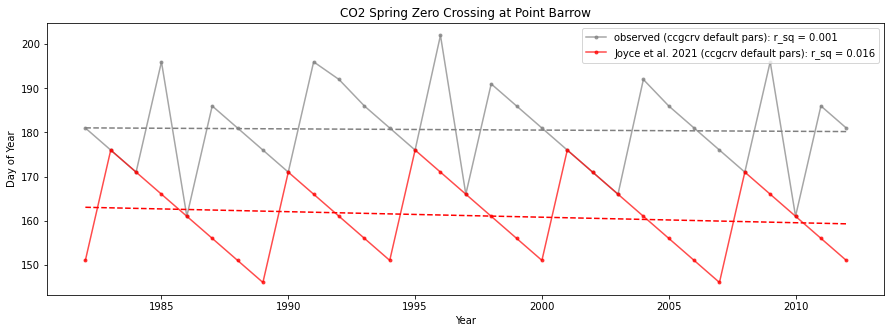

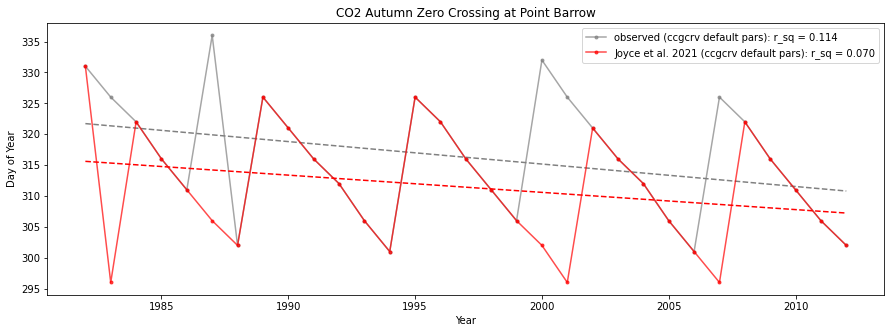

In [25]:
# Plot of CO2 crossing down of trend line
plot_linreg(tcross_year, tcross_obs['tcdown_doy'], col='grey', fmt='.-', lab='observed (ccgcrv default pars)')
plot_linreg(tcross_year, tcross_joyce['tcdown_doy'], col='red', fmt='.-', lab='Joyce et al. 2021 (ccgcrv default pars)')

plt.legend(loc="upper right")
plt.title('CO2 Spring Zero Crossing at Point Barrow')
plt.ylabel('Day of Year')
plt.xlabel('Year')
plt.show()

# Plot of CO2 crossing up of trend line
plot_linreg(tcross_year, tcross_obs['tcup_doy'], col='grey', fmt='.-', lab='observed (ccgcrv default pars)')
plot_linreg(tcross_year, tcross_joyce['tcup_doy'], col='red', fmt='.-', lab='Joyce et al. 2021 (ccgcrv default pars)')

plt.legend(loc="upper right")
plt.title('CO2 Autumn Zero Crossing at Point Barrow')
plt.ylabel('Day of Year')
plt.xlabel('Year')
plt.show()
